In [375]:
import csv
import seaborn as sns
import pandas as pd
import sys
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [352]:
def moving_average(arr, window_size):
    i = 0
    moving_averages = []

    while i < len(arr) - window_size + 1:
        window = arr[i : i + window_size]
        window_average = round(sum(window) / window_size, 2)
        moving_averages.append(window_average)

        i += 1

    return moving_averages


In [420]:
opponent = "ZIC"

opponent_sum = 0
DTR_sum = 0
opc, dtrc = 0, 0

df = pd.DataFrame(columns=[opponent, "DTR"])
norm_df = pd.DataFrame(columns=[opponent, "DTR"])

for i in range(1,11):
    norm_batch = pd.DataFrame(columns=[opponent, "DTR"])
    with open(f"experiment-data/00-10-00-00-00-00-10:{i}.csv", newline="") as csvfile:
        reader = csv.reader(csvfile)
        
        for row in reader:
            if opponent == "AA":
                opp_profit = float(row[4])
                dtr_profit = float(row[11])
            else:
                opp_profit = float(row[11])
                dtr_profit = float(row[4])

            if dtr_profit > opp_profit * 3 or dtr_profit * 3 < opp_profit:
                continue

            opponent_sum += opp_profit
            DTR_sum += dtr_profit

            if dtr_profit > opp_profit:
                dtrc += 1
            else:
                opc += 1

            new_row = pd.DataFrame({opponent: opp_profit, "DTR": dtr_profit}, index=[0])
            df = pd.concat([df, new_row], ignore_index=True)
            norm_batch = pd.concat([norm_batch, new_row], ignore_index=True)
    
    # norm_batch["DTR"] = (norm_batch["DTR"] - norm_batch["DTR"].mean()) / norm_batch["DTR"].std()
    # norm_batch["OPP"] = (norm_batch["OPP"] - norm_batch["OPP"].mean()) / norm_batch["OPP"].std()

    batch_min_dtr = norm_batch["DTR"].min() # 2656
    batch_max_dtr = norm_batch["DTR"].max() # 100000

    batch_max_opp = norm_batch[opponent].max()
    batch_min_opp = norm_batch[opponent].min()

    norm_batch["DTR"] = (norm_batch["DTR"] - batch_min_dtr) / (batch_max_dtr - batch_min_dtr)
    norm_batch[opponent] = (norm_batch[opponent] - batch_min_opp) / (batch_max_opp - batch_min_opp)
    
    norm_df = pd.concat([norm_df, norm_batch], ignore_index=True)

In [421]:
def calc_confidence_interval(data):
    n = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)

    # Calculate the standard error and margin of error for a 95% confidence interval
    se = std / np.sqrt(n)
    moe = stats.t.ppf(0.95, df=n-1) * se

    # Calculate the confidence interval
    ci_lower = mean - moe
    ci_upper = mean + moe

    return (ci_lower, ci_upper)

ci_lower, ci_upper = calc_confidence_interval(df['DTR'])
print(f"The 90% confidence interval for the DTR mean is ({ci_lower:.2f}, {ci_upper:.2f})")
print('DTR mean:', int(df['DTR'].mean()), 'DTR std:', int(df['DTR'].std()))

ci_lower, ci_upper = calc_confidence_interval(df[opponent])
print(f"The 90% confidence interval for the {opponent} mean is ({ci_lower:.2f}, {ci_upper:.2f})")
print(f'{opponent} mean:', int(df[opponent].mean()), f'{opponent} std:', int(df[opponent].std()))


The 90% confidence interval for the DTR mean is (1237.77, 1318.19)
DTR mean: 1277 DTR std: 542
The 90% confidence interval for the ZIC mean is (1291.34, 1376.35)
ZIC mean: 1333 ZIC std: 573


In [422]:
# Print the result
print(f"{opponent}_sum: {int(opponent_sum)}")
print(f"DTR_sum: {int(DTR_sum)}")

print("DTR wins:", dtrc, f"{opponent} wins:", opc)

print(f"{opponent} mean profit: {int(df[opponent].mean())}, and standard deviation: {int(df[opponent].std())}")
print(f"DTR mean profit: {int(df['DTR'].mean())}, and standard deviation: {int(df['DTR'].std())}")

ZIC_sum: 658921
DTR_sum: 631323
DTR wins: 235 ZIC wins: 259
ZIC mean profit: 1333, and standard deviation: 573
DTR mean profit: 1277, and standard deviation: 542


In [423]:
for col in df.columns:
    shapiro_test = stats.shapiro(df[col])
    print("Test for col", col, ":", shapiro_test)
    print("Test for scaled col", col, ":", stats.shapiro(norm_df[col]))
    print("Test for scaled col", col, ":", stats.normaltest(norm_df[col]), "\n")
    print("Test for col", col, ":", stats.kstest(norm_df[col], stats.norm.cdf), "\n")

Test for col ZIC : ShapiroResult(statistic=0.9793292880058289, pvalue=1.8023391703536618e-06)
Test for scaled col ZIC : ShapiroResult(statistic=0.9591807723045349, pvalue=1.8316763383818824e-10)
Test for scaled col ZIC : NormaltestResult(statistic=45.32789197455894, pvalue=1.4360624271991046e-10) 

Test for col ZIC : KstestResult(statistic=0.5, pvalue=1.0028427961635053e-114) 

Test for col DTR : ShapiroResult(statistic=0.9884273409843445, pvalue=0.0005990697536617517)
Test for scaled col DTR : ShapiroResult(statistic=0.9716537594795227, pvalue=3.491095412755385e-08)
Test for scaled col DTR : NormaltestResult(statistic=44.36865556803302, pvalue=2.319897830019874e-10) 

Test for col DTR : KstestResult(statistic=0.5, pvalue=1.0028427961635053e-114) 



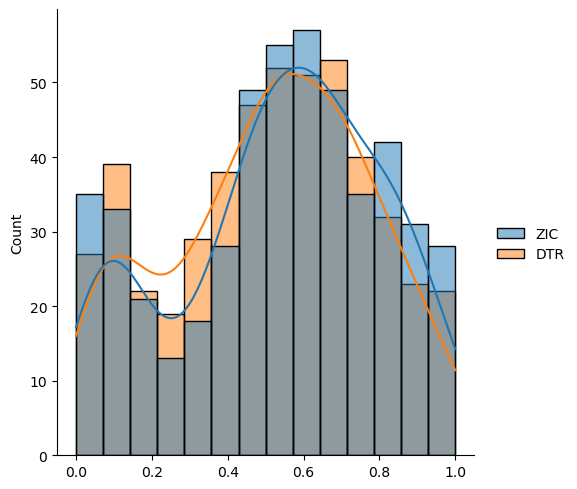

In [424]:
sns.displot(norm_df, kde=True)
# sns.boxplot(data=df)
plt.show()

In [425]:
print(stats.ttest_ind(norm_df["DTR"], norm_df[opponent]))
print(stats.ttest_rel(norm_df["DTR"], norm_df[opponent]), '\n')

print(stats.wilcoxon(df["DTR"], df[opponent]))
print(stats.mannwhitneyu(df["DTR"], df[opponent]))
print(stats.kruskal(df["DTR"], df[opponent]))

Ttest_indResult(statistic=-1.3755587788089487, pvalue=0.16927068111014576)
Ttest_relResult(statistic=-1.4992234177452985, pvalue=0.13445574090869825) 

WilcoxonResult(statistic=54480.0, pvalue=0.04296888299370921)
MannwhitneyuResult(statistic=114496.5, pvalue=0.09353638792303622)
KruskalResult(statistic=2.8128074826543608, pvalue=0.09351458961280881)


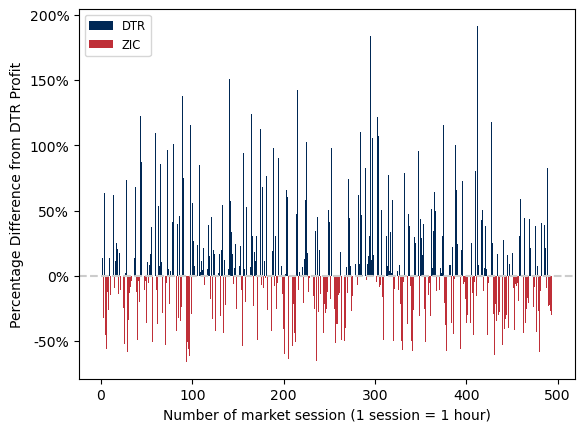

In [426]:
plt.xlabel("Number of market session (1 session = 1 hour)")
plt.ylabel('Percentage Difference from DTR Profit')
x_ticks = [i for i in range(1, len(df["DTR"]) + 1)]

diff_profits = (df["DTR"] - df[opponent]) / np.abs(df[opponent]) * 100
colors = ["#002855" if p > 0 else "#BF2F38" for p in diff_profits]

plt.bar(x_ticks, diff_profits, color=colors)
plt.axhline(y=0, color="#CCCCCC", linestyle="--")

plt.gca().yaxis.set_major_formatter('{:.0f}%'.format)

dtr_label = plt.Rectangle((0, 0), 1, 1, fc="#002855", edgecolor='none')
opponent_label = plt.Rectangle((0, 0), 1, 1, fc="#BF2F38", edgecolor='none')
plt.legend([dtr_label, opponent_label], ['DTR', opponent], loc='upper left', fontsize='small')

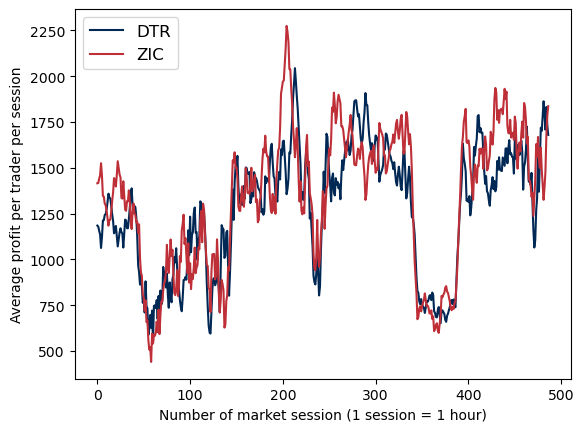

In [427]:
fig, ax = plt.subplots()

plt.xlabel("Number of market session (1 session = 1 hour)")
plt.ylabel('Average profit per trader per session')

ax.plot(moving_average(df["DTR"],8), color="#002855", label="DTR")
ax.plot(moving_average(df[opponent],8), color="#BF2F38", label=opponent)

legend = ax.legend(loc="upper left", shadow=False, fontsize="large")